### 该脚本将DMS JSON中的手部标注框信息提取出来，并转换为voc xml格式   

#### 注意：实际使用时发现不需要转成xml，直接输出txt格式就可以。不过保留了bbox to xml格式的脚本，可以留着以后使用（如TF Object Detection训练faster rcnn）

In [44]:
import os
import pdb
from tqdm import tqdm
from lxml import etree, objectify
from glob import glob
import dms_json
import cv2
import re
import dataset_hand
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

#### Step1: bbox to xml

In [117]:
def bbox_to_xml(boxes, filename, category='dms_hand'):
    img_suffix = filename[-4:]
    E = objectify.ElementMaker(annotate=False)
    anno_tree = E.annotation(
        E.folder(category),
        E.filename(filename),
        E.path(os.path.abspath(filename)),
        E.source(
            E.database('COCO'),
        ),
        E.size(
            E.width(640),
            E.height(480),
            E.depth(3)
        ),
        E.segmented(0),
    )
    for box in boxes:
        xmin,ymin,xmax,ymax = box
        E2 = objectify.ElementMaker(annotate=False)
        anno_tree2 = E2.object(
            E.name('hand'),
            E.pose("Unspecified"),
            E.truncated(0),
            E.difficult(0),

            E.bndbox(
                E.xmin(xmin),
                E.ymin(ymin),
                E.xmax(xmax),
                E.ymax(ymax)
            )
        )
        anno_tree.append(anno_tree2)
    etree.ElementTree(anno_tree).write(filename.rstrip(img_suffix)+'.xml', pretty_print=True)

*Step1 Checking:*
``` python
Left=664
Top=205
Right=865
Bottom=664
boxes = [[Left,Top,Right,Bottom]]
TEST_IMG_PATH = 'images/'
image_list = glob(TEST_IMG_PATH+'*.png')
bbox_to_xml(boxes,image_list[0])
```

#### Step2: DMS_json to YOLO_txt格式

首先，从整体上来说，需要对`/mnt/hdfs-data-3/data/zhenghua.chen/DMS_Data/Data_Hand/python/dataset_hand.py`中列出的所有数据patch过一遍。  

具体到每一个patch中的每一个子文件夹，我需要通过json_parser过滤出没有手的样本，对于有手的样本，要将hand_box返回，形式为 [[x0_1,y0_1,x0_2,y0_2],[x1_1,y1_1,x1_2,y1_2]] 这样的嵌套列表。  

另外，yolo中box的格式和dms_json中不同，需要转换一下。  

最后将转换后的bbox输出到txt文件中。每个样本一个txt，若包含多个目标则写到下一行中

* Step2_1: 处理每个子文件夹中的每一张图像

In [48]:
OUTPUT_DIR = '/mnt/hdfs-data-2/data/chengyuan.yang/DMS/Prepare_YOLO_Annotition/Outputs'
TRAIN_TXT_LIST = []

In [49]:
def convert_bbox(box):
    '''原box格式: xmin,ymin,xmax,ymax
       输出box格式：yolo格式：x_center/W, y_center/H, w/W, h/H
    '''
    x = (box[0] + box[2])/2.0
    y = (box[1] + box[3])/2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x, w, y, h = x/1280, w/1280, y/720, h/720
    return [x,y,w,h]
def create_txt_one_line(line, img_folder_name, saving_dir, viz=False):
    '''该函数处理一个json文件的一行（即一张图像），读取dms_json中该图像所有的hand_box信息，输出到一个与图像同名的txt中'''
    if line[0] == '#':
        return
    image_arrt = dms_json.DMSJsonParser()
    try:
        if image_arrt.ParseJsonRaw(line) == False:
            return
    except:
        return
    #pdb.set_trace()
    if image_arrt.hasDriver == False:
        return
    if len(image_arrt.driverLandmark) == 0:
        return
    if image_arrt.handNum == 0:
        return
    img_name = image_arrt.imgName 
    if img_name is None:
        return
    bboxes = image_arrt.handBoxes
    if len(bboxes)==0:
        return
    txt_file = open(saving_dir+'/'+img_name[:-4]+'.txt', 'w')
    new_bboxes = []
    for bbox in bboxes:
        bbox = convert_bbox(bbox)
        new_bboxes.append(bbox)
        txt_file.write('0 '+' '.join([str(x) for x in bbox])+'\n')
    TRAIN_TXT_LIST.append(os.path.join(img_folder_name,img_name))
    txt_file.close()
    if viz:
        plt.clf()
        with open(saving_dir+'/'+img_name[:-4]+'.txt','r') as f:
            content = f.readlines()
        nume_info = re.findall(r"\d+\.?\d*",content[0])
        box = [float(x) for x in nume_info[1:]]
        img = cv2.imread(img_folder_name +'/'+ image_arrt.imgName,0)
        plt.imshow(img,'gray')
        bbox = return_to_bbox(box)
            #pdb.set_trace()
        plt.gca().add_patch(plt.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,color='red'))
        plt.show()
        fig.canvas.draw()
#     print("Successfully write txt")
def create_txt_one_json(json_file_name, data_name, img_dir):
    '''遍历一个json文件所有行'''
    with open(json_file_name,'r') as f:
        json_file = f.readlines()
    base_file_name = os.path.basename(json_file_name)
    json_fn_pfx = os.path.splitext(base_file_name)[0]
    img_folder_name = os.path.join(img_dir, json_fn_pfx)
    saving_dir = os.path.join(OUTPUT_DIR, data_name,json_fn_pfx)  # Project_Dir/Patch_name/5355/
    if not os.path.exists(saving_dir):
        os.makedirs(saving_dir)
    for line in json_file:
        _=create_txt_one_line(line, img_folder_name, saving_dir,viz=False)
    print('Successfully processed json file : {}'.format(json_fn_pfx))
def create_txt_one_patch(data_name):
    '''遍历一个data_patch(如patch_201805这种)的所有json文件'''
    json_dir, img_dir = dataset_hand.GetDatabase(data_name, data_type='train')
    json_file_list = glob(json_dir + '/*.json')
    for json_file_name in json_file_list:
        create_txt_one_json(json_file_name, data_name, img_dir)
    print('[+][+] Successfully processed data patch : {} [+][+]'.format(data_name))

<IPython.core.display.Javascript object>


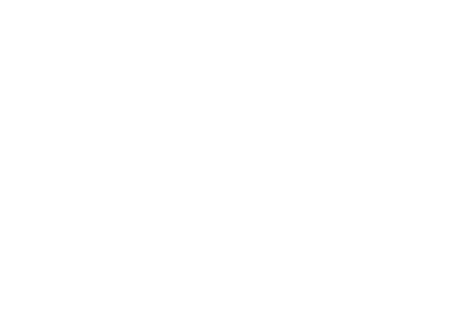

Successfully processed json file : 5422
Successfully processed json file : 5419
Successfully processed json file : 5403
Successfully processed json file : 5401
Successfully processed json file : 5386
Successfully processed json file : 5430
Successfully processed json file : 5391
Successfully processed json file : 5429
Successfully processed json file : 5424
Successfully processed json file : 5442
Successfully processed json file : 5435
Successfully processed json file : 5404
Successfully processed json file : 5406
Successfully processed json file : 5399
Successfully processed json file : 5381
Successfully processed json file : 5398
Successfully processed json file : 5361
Successfully processed json file : 5409
Successfully processed json file : 5375
Successfully processed json file : 5377
Successfully processed json file : 5388
Successfully processed json file : 5410
Successfully processed json file : 5393
Successfully processed json file : 5428
Successfully processed json file : 5436


In [50]:
%matplotlib notebook
patch_list = ['patch_201805','patch_201806','tianjin201806','plus_20180622','pts72_refresh','plus_20180709',
             'tianjin201806_plus_20180718','tianjin201806_plus_20180702','tianjin201806_plus_201808',
             'pts72_refresh_plus_20180702','pts72_refresh_plus_20180718','pts72_refresh_plus_201808']

# 这里只使用了patch_201805作为例子。如果要使用全部patch，使用整个patch_list即可
test_patch_list = ['patch_201805']
fig = plt.figure()
for patch in test_patch_list:
    create_txt_one_patch(data_name=patch)

* 全局列表TRAIN_TXT_LIST保存了所有存在手的图像名称。先将其写入一个txt，后续需要利用该txt将所有图像数据copy到同一个文件夹

In [5]:
train_lst = open('Outputs/train_list.txt','w')
for line in TRAIN_TXT_LIST:
    train_lst.write(line)
    train_lst.write('\n')
train_lst.close()

In [6]:
len(TRAIN_TXT_LIST)

50828

#### Step3: 检查生成的txt标注是否正确

In [3]:
def return_to_bbox(box):
    W = 1280
    H = 720
    left = box[0]*W - 0.5*box[2]*W
    top = box[1]*H - 0.5*box[3]*H
    return [left, top, W*box[2], H*box[3]]


#### Step3: 检测生成的xml是否正确（用不到）

In [71]:
def get_bbox(xml_name):
    bboxx = []
    tree = etree.parse(xml_name)
    for bbox in tree.xpath('//bndbox'):
        for corner in bbox.getchildren():
            bboxx.append(int(corner.text))
    return bboxx
def check_labels(folder_name, id):
    img_list = []
    for ext in ('*.png', '*.jpg'):
        img_list.extend(glob(os.path.join(folder_name, ext)))
    img_list = glob(folder_name + '/*.png')
    xml_list = glob(folder_name + '/*.xml')
    i0 = img_list[id]
    l0 = xml_list[id]
    bx = get_bbox(l0)
    img = io.imread(i0)
    plt.imshow(img[bx[1]:bx[3],bx[0]:bx[2]])

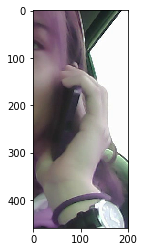

In [74]:
check_labels('images/',0)

In [69]:
img_list = []
for ext in ('*.png', '*.jpg'):
    img_list.extend(glob(os.path.join("images", ext)))

### 实验区

In [86]:
data_name, data_type = 'patch_201805','train'
json_dir, img_dir = dataset_hand.GetDatabase(data_name, data_type)
json_file_list = glob(json_dir + '/*.json')

In [104]:
json_file_name = json_file_list[0]

In [105]:
with open(json_file_name,'r') as f:
    json_lines = f.readlines()

In [136]:
base_file_name = os.path.basename(json_file_name)
json_fn_pfx = os.path.splitext(base_file_name)[0]
img_folder_name = os.path.join(img_dir, json_fn_pfx)
line0 = json_lines[100]

In [147]:
' '.join([str(x) for x in [1,2,3,4]])

'1 2 3 4'

In [ ]:
base_file_name = os.path.basename(json_file_name)
json_fn_pfx = os.path.splitext(base_file_name)[0]
img_folder_name = os.path.join(img_dir, json_fn_pfx)
line0 = json_lines[100]
saving_dir = os.path.join(OUTPUT_DIR, data_name,json_fn_pfx)

get_bbox_one_line(json_lines[121], json_fn_pfx)

把生成的txt cp到data/labels下

``` python 
!bash cp_txt_one_patch.sh patch_201805
```

In [11]:
!ls -c Outputs/patch_201805/

5405  5402  5378  5357	5441  5414  5355  5376	5385  5428  5375  5406	5430
5356  5421  5412  5380	5397  5362  5444  5439	5437  5393  5409  5404	5386
5438  5384  5358  5432	5415  5427  5383  5382	5392  5410  5361  5442	5401
5396  5431  5411  5408	5407  5360  5379  5433	5440  5388  5398  5424	5403
5445  5359  5434  5423	5417  5400  5420  5413	5425  5435  5381  5429	5419
5394  5418  5395  5443	5426  5387  5390  5416	5436  5377  5399  5391	5422
